In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.cluster import KMeans

import lightgbm as lgb
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from joblib import Parallel, delayed
from sklearn.preprocessing import OrdinalEncoder

In [13]:
df = pd.read_pickle('../preprocessing/preprocess_df.pkl')

In [26]:
non_numeric_columns = df.select_dtypes(exclude=['int', 'float', 'bool']).columns.tolist()
oe = OrdinalEncoder()
encoded_df = pd.DataFrame(oe.fit_transform(df[non_numeric_columns].values))
encoded_df.columns = non_numeric_columns

df.drop(non_numeric_columns, axis=1, inplace=True)

df = pd.concat([df.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)

In [32]:
trainval_df = df[~df['price'].isna()]
test_df = df[df['price'].isna()]

del df

In [33]:
ID = 'id'
TARGET = 'price'
drop_list = [ID, TARGET]
trainval_x = trainval_df.drop(drop_list, axis=1)
trainval_y = trainval_df[TARGET]
test_x = test_df.drop(drop_list, axis=1)
test_y = test_df[TARGET]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


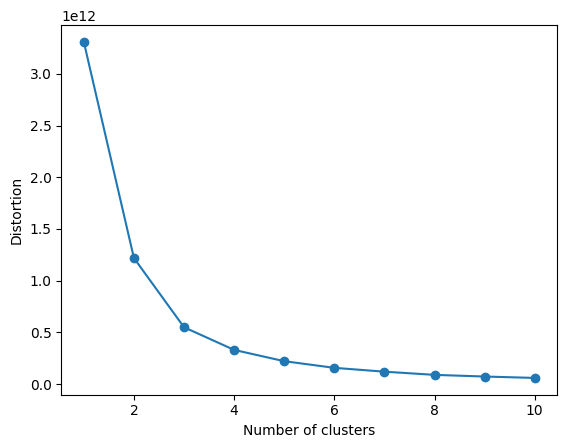

In [34]:
distortions = []
for i  in tqdm(range(1,11)):                # 1~10クラスタまで一気に計算 
    km = KMeans(n_clusters=i,
                init='k-means++',     # k-means++法によりクラスタ中心を選択
                n_init=10,
                max_iter=300,
                random_state=0)
    km.fit(trainval_y.values.reshape(-1,1))                         # クラスタリングの計算を実行
    distortions.append(km.inertia_)   # km.fitするとkm.inertia_が得られる

plt.plot(range(1,11),distortions,marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [35]:
km = KMeans(n_clusters=4,init='k-means++',n_init=10,max_iter=300,random_state=0)
train_y_class = km.fit_predict(trainval_y.values.reshape(-1,1))

In [36]:
SEED = 42

params = {
    'objective': 'mape',
    'metric': 'mape',
    'num_leaves': 40,
    'max_depth': 7,
    "feature_fraction": 0.8,
    'subsample_freq': 1,
    "bagging_fraction": 0.95,
    'min_data_in_leaf': 2,
    'learning_rate': 0.05,
    "lambda_l1": 0.1,
    "lambda_l2": 10,
    "verbosity": -1,
    "random_state": 42,
    "num_boost_round": 100000,
    "early_stopping_rounds": 300,
    "boosting": "gbdt"
    
}

def one_fold(fold, train_idx, val_idx):
    print('fold', fold)
    X_train, X_val = trainval_x.iloc[train_idx,:], trainval_x.iloc[val_idx,:]
    y_train, y_val = trainval_y.iloc[train_idx], trainval_y.iloc[val_idx]

    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val)

    model = lgb.train(
        params,
        train_data, 
        valid_names = ['train', 'valid'],
        valid_sets =[train_data, val_data]
    )
    _oof = model.predict(X_val, num_iteration=model.best_iteration)
    score = np.mean(np.abs((y_val - _oof) / y_val)) * 100
    pred = model.predict(test_x.values)

    return [val_idx, model, _oof, score, pred]

In [37]:
oof_skf = np.zeros_like(trainval_y)
pred_skf = np.zeros_like(test_y)
models_skf, scores_skf, val_idxs_skf = [],[],[]

skf = StratifiedKFold(n_splits=5, shuffle=True)
result = Parallel(n_jobs=-1, verbose=0)(delayed(one_fold)(fold, trn_idx, val_idx)
    for fold, (trn_idx, val_idx) in enumerate(skf.split(trainval_x, train_y_class)))

fold 1


/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


fold 0
fold 4
fold 2
fold 3


/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [38]:
for val_idx,model, _oof, score, _pred in result:
    oof_skf[val_idx] = _oof
    pred_skf += _pred / 5
    val_idxs_skf.append(val_idx)
    models_skf.append(model)
    scores_skf.append(score)

In [52]:
test_df = test_df.drop(TARGET, axis=1)
test_df[TARGET] = pred_skf

sub_df = pd.read_csv('../data/submit_sample.csv', header=None)
sub_df.columns = [ID, TARGET]
sub_df = pd.merge(sub_df[[ID]], test_df[[ID, TARGET]], on=ID, how='left')
sub_df.to_csv('../basemodel_submission.csv', index=False)

In [57]:
sum(scores_skf)/len(scores_skf)

48.76005993649639

In [53]:
# basemodel public score
# 評価結果：48.3451957438268

id       0
price    0
dtype: int64